In [1]:
import os
import sys
import zipfile 
import pandas as pd
from upload import retrieve_file
import warnings
from stim_adj import stim_adj
import autograd.numpy as np 
from autograd import grad, jacobian
from scipy import optimize
from param_adj import param_adj
import matplotlib.pyplot as plt

In [6]:
class ParameterRecovery:
    def __init__(self, known_params, unknown_params, dt = 0.0125, neuron_type= 'L5PC', num_ap = 1, V_data = None, I_data = None, t_data = None, method = 'BFGS', bounds = {}, tol = 100): 
        '''
        For known parameters of the Hodgkin Huxley set the upper and lower bounds equal to that float
        Objective: 
        
        Args: 
            known_params (dict): known parameters and their values
            unknown_parameters (dict): unknown parameters and their intial guesses -- if different than standard
            neuron_types (str): 
            num_ap (int):
            V_data ():
            I_data ():
            t_data ():
            bounds ():
            method (str): with bo
        
        Returns: 
            '''
        self.neuron_type = neuron_type
        self.num_ap = num_ap
        self.known_params = known_params
        self.unknown_params = unknown_params
        self.params = {**self.known_params, **self.unknown_params}
        self.HH_var = ['g_Na', 'g_K', 'g_L', 'E_Na', 'E_K', 'E_L', 'C_m', 'm', 'h', 'n']
        self.param_list = list(self.params.keys())
        self.missing = list(set(self.HH_var) - set(self.param_list))
        self.unknown_keys = list(self.unknown_params.keys()) + self.missing
        
        self.dt = dt
    
        #default parameter setting HH model parameters
        
        self.g_Na = 120.0
        self.g_K = 36.0
        self.g_L = 0.3
        self.E_Na = 50.0
        self.E_K = -85.0
        self.E_L = -90
        self.C_m = 1.0
        self.m = 0.05
        self.n = 0.6
        self.h =  0.32
        self.standard_params = {'g_Na' :  self.g_Na , 'g_K' : self.g_K, 'g_L': self.g_L, 'E_Na': self.E_Na, 'E_K': self.E_K, 'E_L': self.E_L, 'C_m': self.C_m, 'm': self.m, 'h': self.h, 'n': self.n }
        #manual input variables 
        self.V_data = V_data
        self.I_data = I_data 
        self.t_data = t_data 
        #self.t_final = t_data[-1]
        
        #retrieved simulation parameter
        self.t_sim = np.arange(0, 250, self.dt)
        
        #creating instance to load specific neuron data
        self.inst_file = retrieve_file(self.neuron_type, self.num_ap, self.V_data, self.I_data, self.t_data)
        
        #initialize variables dependent on ground truth data (from upload.py)
        instance = self.inst_file
        initialized = instance.load()
    
            
        #if manual entry is not choosen, upload from initialized 
        if self.V_data is None:
            self.V_data = initialized[0]
        else: 
            self.V_data = V_data
        if 'stim' not in self.unknown_params: 
            if self.I_data is None:
                self.I_data = initialized[1]
        if self.t_data is None: 
            self.t_data = initialized[2]
                   
        self.V0 = self.V_data[0]
        self.data_steps = self.t_data[1] - self.t_data[0]

        #optimizaton parameters
        #check that if bounds are given the optimal method is given 
        
        self.bounds = bounds
        if 'stim' in self.unknown_params and self.bounds is None: 
                warnings.warn("No bounds given, recommended methods to be CG or BFGS") #also want that no known values given 
        self.method = method
        self.tol = tol

    def assign_parameters(self):
        if 'stim' in self.unknown_params: 
            warnings.warn('If input stimuli is unknown, can only invert for features of the stimuli, all other parameters will be assumed to be known and set to default')
        for key, value in self.known_params.items():
            globals()[key] = value
        for key, value in self.unknown_params.items():
            globals()[key] = value
        missing_values = list(set(self.HH_var) - set(self.param_list))
        str_missing = ' '.join(missing_values)
        warnings.warn(f'The following variables were not defined or given an initial guess  {str_missing}. We will assume default values for an initial guess and that these values are unknown')
        
        #update parameters based on given known values
        
        return self.param_list
    
    def define_bounds(self):
        '''
        defines the bounds for optimiatoin setting upper and lower limits equal to known values
        '''
        if 'stim' in self.unknown_params: 
            optim_bounds = self.bounds
        else:
            optim_bounds = []
            for item in self.HH_var:
                if item in self.bounds: 
                    item_bound = self.bounds[item]
                elif item in self.known_params:
                    item_bound = (self.known_params[item], self.known_params[item])
                else: 
                    item_bound = (-float('inf'), float('inf'))
                optim_bounds.append(item_bound)
        return optim_bounds
                    
                    
    def def_guess_params(self):
        stim_guess = []
        HH_guess = []
        if 'stim' in self.unknown_params: 
            stim_guess.append(self.unknown_params['stim'])
            for item in self.HH_var:
                if item in self.known_params: 
                    HH_guess.append(self.known_params[item])
                else: 
                    HH_guess.append(self.standard_params[item])
        else: 
            for item in self.HH_var:
                if item in self.unknown_params: 
                    stim_guess.append(self.unknown_params[item])
                elif item in self.known_params: 
                    stim_guess.append(self.known_params[item])
                else: 
                    stim_guess.append(self.standard_params[item])
        return stim_guess, HH_guess
                         
    def adj_impulse(self): 
        params = self.def_guess_params()
        stim_params = params[0]
        HH_params = params[1]
        print(HH_params)
        #impulse_inst= stim_adj(self.V_data, self.t_data, self.dt, HH_params, stim_params[0][0], stim_params[0][1], stim_params[0][2], self.bounds, self.method)
        impulse_inst= stim_adj(self.V_data, self.t_data, self.dt, HH_params, stim_params[0][0], stim_params[0][1], self.bounds, self.method)
        optim, V_final = impulse_inst.recovery()
        return optim, V_final
    
    def adj_param(self): 
        params = self.def_guess_params()
        HH_params = params[1]
        param_inst = param_adj(self.V_data, self.t_data, self.I_data, self.dt, self.HH_params, self.bounds, self.method, tol)
        #optim = param_inst.optimize()
        optim, V_final = param_inst.recovery()
        return optim, V_final
    
    def optimize(self): 
        if 'stim' in unknown_params: 
            optim_sol = self.adj_impulse()
        else: 
            optimal_sol = self.adj_param()
        return optimal_sol
    
    
    def graph(self, V_final):

        plt.figure()
        plt.plot(self.t_sim, V_final, ls = 'dotted', label = 'optimized spike train')
        plt.plot(self.t_data, self.V_data, label = 'target spike train')
        plt.xlabel('Time')
        plt.ylabel('Voltage')
        plt.legend()
        

MISC Testing: 

In [3]:
y = [(1, 2, 3)]
print(y[0][0])

1


In [4]:
#test = ParameterRecovery({'Na': 120, 'g_Na' : 5}, {'K': 5, 'stim': (5.0, 2.0, 152.525)}, bounds = {'E_L': (0, 10)})
test = ParameterRecovery({'Na': 120, 'g_Na' : 5}, {'K': 5, 'stim': (5.0, 2.0)}, bounds = {'E_L': (0, 10)})
test.assign_parameters()
test.unknown_keys
x = test.define_bounds()







Default choosen of 1 Action Potential


/var/folders/6j/fcfm9_6n3rg0rg4_4flv5ks00000gq/T/ipykernel_85506/1329952150.py:87: UserWarning: If input stimuli is unknown, can only invert for features of the stimuli, all other parameters will be assumed to be known and set to default
  warnings.warn('If input stimuli is unknown, can only invert for features of the stimuli, all other parameters will be assumed to be known and set to default')
/var/folders/6j/fcfm9_6n3rg0rg4_4flv5ks00000gq/T/ipykernel_85506/1329952150.py:94: UserWarning: The following variables were not defined or given an initial guess  E_L E_Na g_K m g_L h E_K C_m n. We will assume default values for an initial guess and that these values are unknown
  warnings.warn(f'The following variables were not defined or given an initial guess  {str_missing}. We will assume default values for an initial guess and that these values are unknown')


In [5]:
y = test.def_guess_params()
print(y)
X, V = test.adj_impulse()
print(X)


([(5.0, 2.0)], [5, 36.0, 0.3, 50.0, -85.0, -90, 1.0, 0.05, 0.32, 0.6])
[5, 36.0, 0.3, 50.0, -85.0, -90, 1.0, 0.05, 0.32, 0.6]


/Users/shoshi/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minimize.py:566: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,
/Users/shoshi/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/Users/shoshi/Desktop/Computational Physics/cphy_final/stim_adj.py:87: RuntimeWarning: invalid value encountered in scalar subtract
  dVdt = (I - self.g_Na * m**3 * h * (V - self.E_Na) - self.g_K * n**4 * (V - self.E_K) - self.g_L * (V - self.E_L)) / self.C_m
/Users/shoshi/Desktop/Computational Physics/cphy_final/stim_adj.py:88: RuntimeWarning: invalid value encountered in scalar multiply
  dmdt = self.alpha_m(V) * (1 - m) - self.beta_m(V) * m
/Users/shoshi/Desktop/Computational Physics/cphy_final/stim_adj.py:89: RuntimeWarning: invalid value encountered in scalar multiply
  dhdt = self.alpha_h(V) * (1 - h) - self.b

[-33394.55250441  69504.16057434]


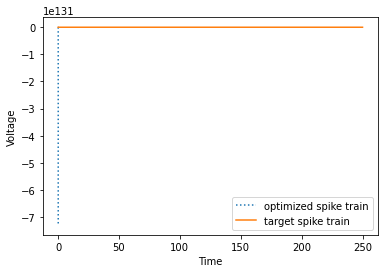

In [6]:
test.graph(V)

In [7]:
test.inst_file
test.inst_file.load()
x = test.inst_file.load()

print(x[0])

Default choosen of 1 Action Potential
Default choosen of 1 Action Potential
[-80.       -80.002106 -80.003914 ... -78.53216  -78.53172  -78.53129 ]


In [8]:
print(x)

(array([-80.      , -80.002106, -80.003914, ..., -78.53216 , -78.53172 ,
       -78.53129 ]), array([0., 0., 0., ..., 0., 0., 0.]), array([0.00000e+00, 2.50000e-02, 5.00000e-02, ..., 2.49950e+02,
       2.49975e+02, 2.50000e+02]), -80.0, 0.025)
